## **Esimated CDF for SM**

Using a fitted polynomial or exponential function may smooth the tail of the distribution too much, eliminating events that are clustered on the far right. Instead, it is possible to make a CDF based on a histogram of discrete values that is smoothed only by choosing the number of bins. This can be normalized in both X and Y directions, so CDF(GeV) returns a correct value and sum(CDF(Gev)) = 1.0 .

In [6]:
import os
import pickle
import numpy as np

# results for 2.5 million events, all params == 0
pT = []
for f in os.listdir('pTs'):
    if f.startswith('SM_1MILLION'):  # bad name! it is really 2.5 million
        with open('pTs/' + f, 'rb') as file:
            pT.append(pickle.load(file)[1])  # pT[1] is list of discrete momenta values
pTs = np.concatenate(pT)

pTs.shape, np.max(pTs), np.mean(pTs), np.sum(pTs > 700)

((3544813,), 763.7138678809587, 33.46773137240907, 7)

In [7]:
BINS = 764  # this is convenient because max is 764, so don't need to scale horizontally

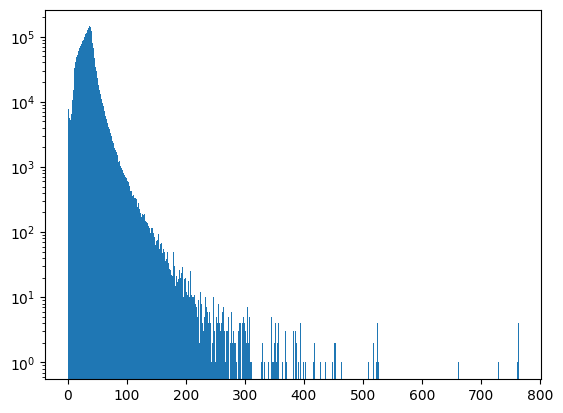

In [8]:
import matplotlib.pyplot as plt
plt.hist(pTs, bins=BINS, log=True)
plt.show()

### **Divide data into bins (with each bin represent 1 Gev), then normalize PDF to sum to 1.0:**

In [9]:
# divide into 1GeV bins
hist, edges = np.histogram(pTs, bins=BINS)

In [10]:
# normalize
pdf = hist / np.sum(hist)
sum(pdf)

0.9999999999999964

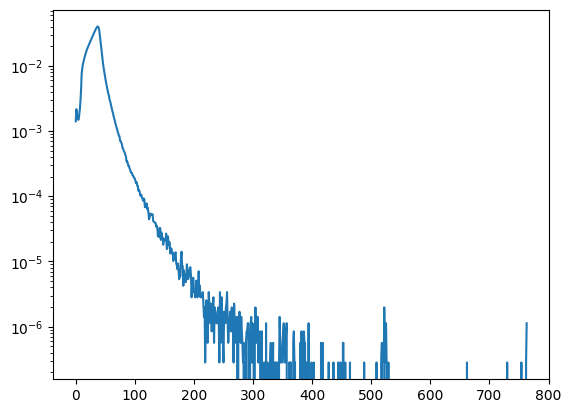

In [11]:
# PDF looks like a continous version of discrete histogram
plt.plot(pdf)
plt.yscale('log')
plt.show()

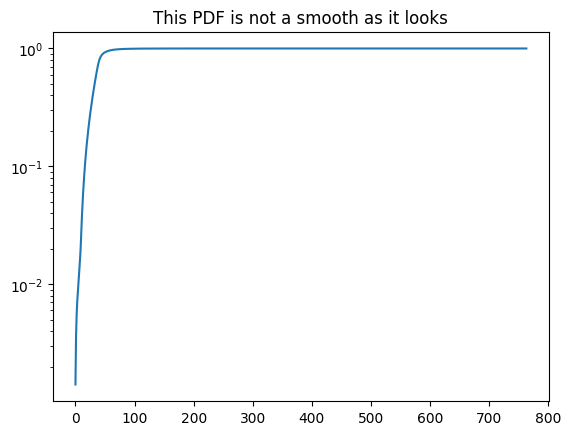

In [12]:
# calculate CDF from discrete PDF
cdf = np.cumsum(pdf)
plt.plot(cdf)
plt.yscale('log')
plt.title('This PDF is not a smooth as it looks')
plt.show()

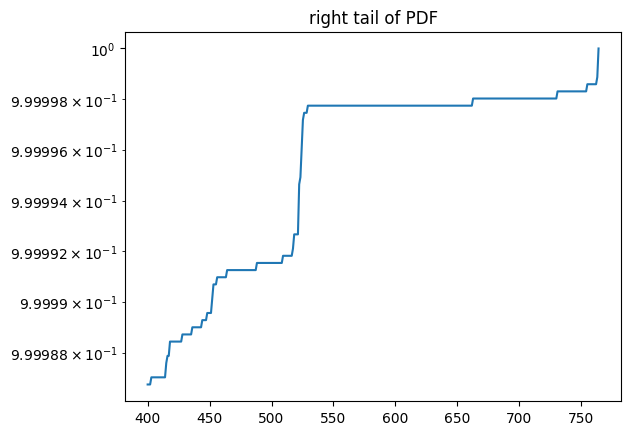

In [13]:
# zoom in
plt.plot(np.linspace(400,BINS,BINS-400), cdf[400:])
plt.yscale('log')
plt.title('right tail of PDF')
plt.show()

### **Create a cdf that takes GeV as input**

In [14]:
cdf[77]

0.9881076942563681

In [15]:
import math

gev = 100.2
width = edges[1]-edges[0]
location = gev/width
left = int(location)
v = cdf[left] + (cdf[left+1]-cdf[left]) * (location-np.floor(location))
v

0.9959661006800381

In [16]:
# bins are scaled to 1GeV (else this will not work)
# TODO: needs horizontal scaling
def my_cdf(gev):
    gev = np.clip(gev,0,BINS-2) # keep one extra bin on right for interpolation
    width = edges[1]-edges[0]
    location = gev/width
    left = location.astype(int)
    return cdf[left] + (cdf[left+1]-cdf[left]) * (location-np.floor(location))

### **Confirm that right tail is not smoothed**

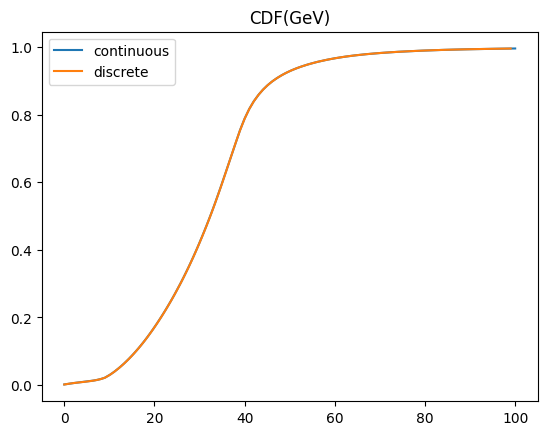

In [17]:
plt.plot(np.linspace(0,100,1000), my_cdf(np.linspace(0,100,1000)), label='continuous')
plt.plot(cdf[0:100], label='discrete')
plt.title('CDF(GeV)')
plt.legend()
plt.show()

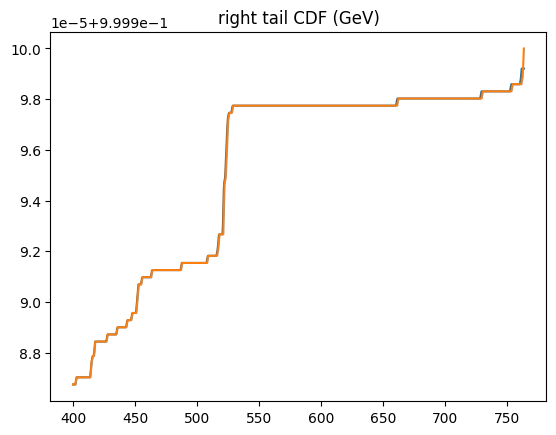

In [18]:
plt.plot(np.linspace(400,BINS,1000), my_cdf(np.linspace(400,BINS,1000)))
plt.plot(np.linspace(400,BINS,BINS-400), cdf[400:BINS])
plt.title('right tail CDF (GeV)') 
plt.show()

### **KS Test with discrete CDF: $O=n log(n)$**

In [19]:
import scipy.stats as stats
stats.kstest(stats.norm.rvs(loc=0, scale=1, size=100_000), my_cdf).statistic # not the same

0.9920545295498081

In [22]:
kstat = []
k2stat = []
for sample_size in np.logspace(3,6,5):
    for i in range(20):
        s = int(sample_size)
        start = np.random.randint(1_000_000)
        kstat.append((s,stats.kstest(pTs[start:start+s],my_cdf).statistic))
        k2stat.append((s,stats.ks_2samp(pTs[0+start:s+start],pTs[s:]).statistic))
kstat = np.array(kstat)
k2stat = np.array(k2stat)

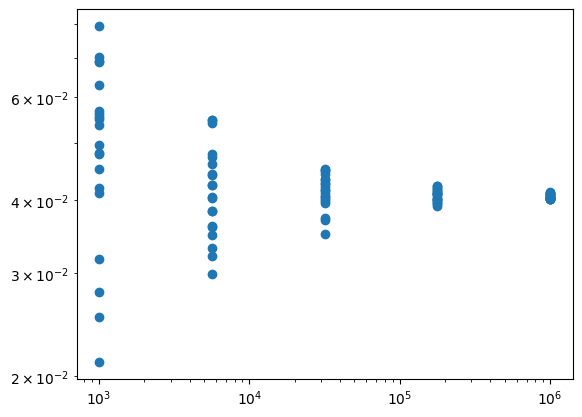

In [24]:
plt.scatter(kstat[:,0], kstat[:,1])
plt.xscale('log')
plt.yscale('log')

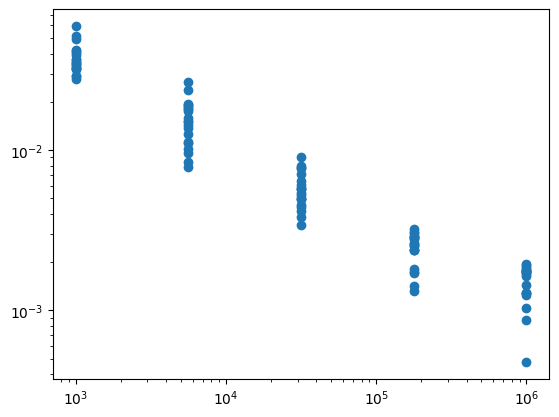

In [25]:
plt.scatter(k2stat[:,0], k2stat[:,1])
plt.xscale('log')
plt.yscale('log')

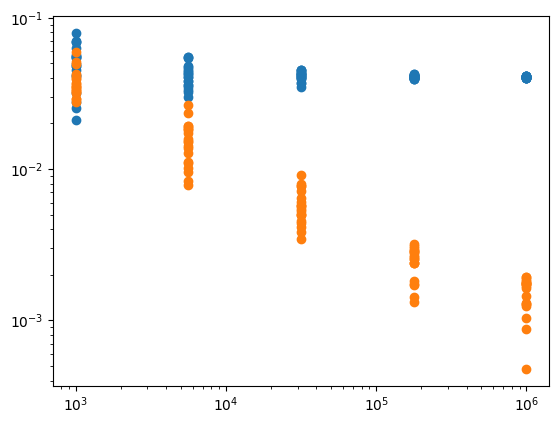

In [23]:
plt.scatter(kstat[:,0], kstat[:,1])
plt.scatter(k2stat[:,0], k2stat[:,1])
plt.xscale('log')
plt.yscale('log')

### **Use CDF to evalute non-SM pT run (re 3323 = 200, im 3323 = 200)**

In [22]:
pT3323 = []
for f in os.listdir('pT_nonSM'):
    if f.startswith('SM.'):  # bad name! it is really nonSM
        with open('pT_nonSM/' + f, 'rb') as file:
            pT3323.append(pickle.load(file)[1])  # pT[1] is list of discrete momenta values
pT3323s = np.concatenate(pT3323)
pT3323s.shape

(354653,)

In [21]:
stats.kstest(pT3323s, my_cdf)

KstestResult(statistic=0.04026933519061893, pvalue=0.0, statistic_location=36.61623096281818, statistic_sign=-1)

### **Use CDF to evalute non-SM pT run (re 3332 = 200, im 3332 = 200)**

In [24]:
pT3332 = []
for f in os.listdir('pT_nonSM'):
    if f.startswith('SM3332'):  # bad name! it is really nonSM
        with open('pT_nonSM/' + f, 'rb') as file:
            pT3332.append(pickle.load(file)[1])  # pT[1] is list of discrete momenta values
pT3332s = np.concatenate(pT3332)
pT3332s.shape

(1071848,)

In [25]:
stats.kstest(pT3332s, my_cdf)

KstestResult(statistic=0.6744871564518833, pvalue=0.0, statistic_location=53.91502448844909, statistic_sign=-1)

In [27]:
stats.kstest(pT3332s[0:25000], my_cdf)

KstestResult(statistic=0.6716939494139856, pvalue=0.0, statistic_location=53.902746030124106, statistic_sign=-1)

### **Use CDF to evalute non-SM pT run (re 3332 = 20, im 3332 = 20)**

In [28]:
pT3332_20_20 = []
for f in os.listdir('pT_nonSM'):
    if f.startswith('SM3332'):  # bad name! it is really nonSM
        with open('pT_nonSM/' + f, 'rb') as file:
            pT3332_20_20.append(pickle.load(file)[1])  # pT[1] is list of discrete momenta values
pT3332_20_20s = np.concatenate(pT3332_20_20)
pT3332_20_20s.shape

(1218884,)

In [29]:
stats.kstest(pT3332_20_20s, my_cdf)

KstestResult(statistic=0.5978511051998807, pvalue=0.0, statistic_location=53.97895649963596, statistic_sign=-1)